In [3]:
# %% [markdown]
# # Exploratory Data Analysis on Merged Game & Twitch Data
# 
# In this notebook we:
# 1. Load the merged dataset.
# 2. Convert date information into a proper datetime object.
# 3. Filter data for the period August 2023 to September 2024.
# 4. Compute descriptive statistics.
# 5. Visualize time-series trends for Steam player counts and Twitch viewership.
# 6. Explore relationships between metrics using scatter plots, correlation matrices, and regression analysis.
# 7. (Optionally) perform time series decomposition.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the merged dataset
df = pd.read_csv('merged_game_twitch_data.csv', encoding='ISO-8859-1')

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Inspect the first few rows
df.head()


,Game_Id,Game_Name,Tags,Month,Avg. Players,Gain,% Gain,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
0,730,Counter-Strike 2,"FPS, Shooter, Multiplayer, Competitive, Action...",Sep-24,836306.66,-61031.22,-6.80%,1473144,09/2024,56131901.0,834364.0,601330.0,110727.0
1,730,Counter-Strike 2,"FPS, Shooter, Multiplayer, Competitive, Action...",Aug-24,897337.88,21972.8,2.51%,1425958,08/2024,62157945.0,866443.0,721256.0,116449.0
2,730,Counter-Strike 2,"FPS, Shooter, Multiplayer, Competitive, Action...",Jul-24,875365.08,-72155.45,-7.62%,1342171,07/2024,40393285.0,786387.0,607518.0,110517.0
3,730,Counter-Strike 2,"FPS, Shooter, Multiplayer, Competitive, Action...",Jun-24,947520.53,-10686.81,-1.12%,1510840,06/2024,43025111.0,761544.0,600631.0,109483.0
4,730,Counter-Strike 2,"FPS, Shooter, Multiplayer, Competitive, Action...",May-24,958207.34,27458.36,2.95%,1614925,05/2024,54980453.0,862006.0,312279.0,120394.0


 ## 2. Date Handling and Filtering
 
 We assume the dataset has either a `Date` column formatted as MM/YYYY or separate `Year` and `Month` columns.
 Here, we try to create a unified `Date` column.


In [6]:
# If there is no unified Date column, create one from 'Year' and 'Month'
if 'Date' not in df.columns:
    # Convert Year and Month to a datetime object using the first day of the month
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
else:
    df['Date'] = pd.to_datetime(df['Date'])

# Sort data by Game_Name and Date
df = df.sort_values(['Game_Name', 'Date']).reset_index(drop=True)
df.head()

C:\Users\nicks\AppData\Local\Temp\ipykernel_21244\3116530077.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Game_Id,Game_Name,Tags,Month,Avg. Players,Gain,% Gain,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
0,1172470,Apex Legends,"Free to Play, Battle Royale, Multiplayer, FPS,...",Nov-20,74957.26,-,-,117193,2020-11-01,43586635.0,2934376.0,266326.0,241200.0
1,1172470,Apex Legends,"Free to Play, Battle Royale, Multiplayer, FPS,...",Dec-20,64469.75,-10487.5,-13.99%,112076,2020-12-01,35472272.0,2536048.0,149460.0,208690.0
2,1172470,Apex Legends,"Free to Play, Battle Royale, Multiplayer, FPS,...",Jan-21,71766.74,7296.99,11.32%,129928,2021-01-01,36579530.0,2836621.0,154317.0,232847.0
3,1172470,Apex Legends,"Free to Play, Battle Royale, Multiplayer, FPS,...",Feb-21,120982.64,49215.9,68.58%,196799,2021-02-01,51757131.0,4059568.0,208798.0,303619.0
4,1172470,Apex Legends,"Free to Play, Battle Royale, Multiplayer, FPS,...",Mar-21,126121.06,5138.42,4.25%,228439,2021-03-01,61043473.0,4108227.0,207842.0,317439.0


## Cell 3: Descriptive Statistics by Game

In [7]:
# List all unique games in the dataset
games = df['Game_Name'].unique()
print("Games in the dataset:", games)

# Show summary statistics for each game
for game in games:
    print(f"\nDescriptive Statistics for {game}:")
    display(df[df['Game_Name'] == game].describe())


Games in the dataset: ['Apex Legends' 'Counter-Strike 2' 'Crab Game' 'Destiny 2' 'Dota 2'
 'Eternal Return' 'MIR4' 'NARAKA: BLADEPOINT' 'Once Human' 'Overwatch 2'
 'PUBG: BATTLEGROUNDS' 'Russian Fishing 4' 'Team Fortress 2' 'VRChat'
 'War Thunder' 'Yu-Gi-Oh! Master Duel']

Descriptive Statistics for Apex Legends:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,48.0,48.000000,48.000000,48,4.800000e+01,4.800000e+01,48.000000,48.000000
mean,1172470.0,164184.783542,362308.312500,2022-09-27 22:00:00,4.307345e+07,2.845488e+06,237187.833333,286708.104167
min,1172470.0,64469.750000,112076.000000,2020-11-01 00:00:00,6.265880e+05,7.476900e+04,47658.000000,33453.000000
25%,1172470.0,134972.185000,266285.500000,2021-10-24 06:00:00,3.190388e+07,2.222354e+06,153102.750000,231064.500000
50%,1172470.0,168476.310000,353141.000000,2022-09-16 00:00:00,3.901094e+07,2.828772e+06,212455.000000,274219.500000
75%,1172470.0,189130.400000,436009.000000,2023-09-08 12:00:00,5.584931e+07,3.492577e+06,291127.000000,337056.000000
max,1172470.0,257416.670000,624473.000000,2024-09-01 00:00:00,9.286405e+07,4.709072e+06,559133.000000,501098.000000
std,0.0,43449.151392,119554.288875,NaN,1.799121e+07,9.126472e+05,117501.660831,89778.190302



Descriptive Statistics for Counter-Strike 2:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,113.0,1.130000e+02,1.130000e+02,113,1.130000e+02,1.130000e+02,1.130000e+02,113.000000
mean,730.0,5.823848e+05,9.685421e+05,2020-07-21 04:53:05.840707840,4.629140e+07,8.488635e+05,4.929529e+05,116580.513274
min,730.0,2.621709e+05,4.202610e+05,2016-01-01 00:00:00,5.264110e+05,9.188000e+03,3.884400e+04,2041.000000
25%,730.0,3.757959e+05,6.674320e+05,2018-05-01 00:00:00,3.076136e+07,6.660470e+05,2.843240e+05,103243.000000
50%,730.0,5.493471e+05,9.253480e+05,2020-09-01 00:00:00,4.499433e+07,8.400930e+05,4.075190e+05,119721.000000
75%,730.0,7.608592e+05,1.199684e+06,2023-01-01 00:00:00,6.089970e+07,9.790170e+05,6.006310e+05,138439.000000
max,730.0,1.117517e+06,1.802853e+06,2024-09-01 00:00:00,9.393092e+07,1.981314e+06,1.916027e+06,215744.000000
std,0.0,2.320478e+05,3.489213e+05,NaN,2.128230e+07,3.507980e+05,3.354499e+05,40247.810676



Descriptive Statistics for Crab Game:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,4.0,4.000000,4.000000,4,4.000000e+00,4.000000,4.000000,4.000000
mean,1782210.0,19391.762500,42084.500000,2022-04-01 18:00:00,4.717975e+06,88164.750000,126834.500000,32037.000000
min,1782210.0,5549.200000,10433.000000,2021-11-01 00:00:00,7.667400e+05,33375.000000,31369.000000,8423.000000
25%,1782210.0,9949.382500,39158.750000,2021-11-23 12:00:00,1.437285e+06,36355.500000,59060.500000,17897.750000
50%,1782210.0,18737.555000,50931.500000,2021-12-16 12:00:00,2.032372e+06,54449.000000,96319.000000,23945.500000
75%,1782210.0,28179.935000,53857.250000,2022-04-24 18:00:00,5.313061e+06,106258.250000,164093.000000,38084.750000
max,1782210.0,34542.740000,56042.000000,2023-04-01 00:00:00,1.404042e+07,210386.000000,283331.000000,71834.000000
std,0.0,13281.964519,21313.736486,NaN,6.250899e+06,83263.185648,111113.073415,27622.849057



Descriptive Statistics for Destiny 2:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,60.0,60.000000,60.000000,60,6.000000e+01,6.000000e+01,60.000000,60.000000
mean,1085660.0,65478.594667,135213.800000,2022-03-17 06:48:00,7.764861e+06,5.962165e+05,110268.850000,54960.566667
min,1085660.0,25233.140000,41373.000000,2019-10-01 00:00:00,2.550236e+06,2.242260e+05,16340.000000,26318.000000
25%,1085660.0,51580.415000,93572.000000,2020-12-24 06:00:00,5.908714e+06,4.443272e+05,31296.500000,42813.750000
50%,1085660.0,62143.780000,118909.500000,2022-03-16 12:00:00,6.985654e+06,5.612005e+05,48179.000000,50098.000000
75%,1085660.0,72234.762500,150771.500000,2023-06-08 12:00:00,8.376856e+06,6.707062e+05,156559.750000,60496.000000
max,1085660.0,165307.820000,316651.000000,2024-09-01 00:00:00,2.457832e+07,1.388181e+06,517758.000000,115103.000000
std,0.0,24571.729845,67545.999377,NaN,3.740811e+06,2.327422e+05,129474.868831,17757.228562



Descriptive Statistics for Dota 2:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,114.0,114.000000,1.140000e+02,114,1.140000e+02,114.000000,1.140000e+02,114.000000
mean,570.0,475852.635175,8.196037e+05,2020-04-15 03:09:28.421052672,3.969532e+07,502617.280702,3.159973e+05,36352.570175
min,570.0,378925.430000,6.164150e+05,2016-01-01 00:00:00,3.762490e+05,13032.000000,6.922000e+03,2010.000000
25%,570.0,428452.095000,7.239228e+05,2018-05-08 18:00:00,3.364860e+07,358230.750000,1.830362e+05,29449.250000
50%,570.0,450487.715000,7.780465e+05,2020-02-01 00:00:00,4.007776e+07,536142.500000,2.421550e+05,34363.000000
75%,570.0,497158.352500,8.689900e+05,2022-04-23 12:00:00,4.678965e+07,667099.000000,3.576968e+05,47225.250000
max,570.0,709178.260000,1.291328e+06,2024-09-01 00:00:00,9.881560e+07,910263.000000,1.636441e+06,68280.000000
std,0.0,72878.136610,1.400058e+05,NaN,1.571119e+07,209590.313211,2.705042e+05,14198.256758



Descriptive Statistics for Eternal Return:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,40.0,40.000000,40.000000,40,4.000000e+01,40.000000,40.000000,40.000000
mean,1049590.0,7098.083250,18418.275000,2022-07-16 07:48:00,2.548126e+06,56893.850000,26791.400000,4439.825000
min,1049590.0,2321.970000,5813.000000,2020-10-01 00:00:00,5.318040e+05,16853.000000,3793.000000,1259.000000
25%,1049590.0,4332.820000,10781.750000,2021-07-24 06:00:00,1.063834e+06,33213.750000,10755.750000,2681.500000
50%,1049590.0,5658.985000,14882.500000,2022-05-16 12:00:00,1.883794e+06,48573.500000,19021.500000,3812.000000
75%,1049590.0,9609.315000,24223.750000,2023-08-08 18:00:00,3.468430e+06,70967.000000,37303.000000,5401.750000
max,1049590.0,20732.170000,52288.000000,2024-09-01 00:00:00,8.658588e+06,155076.000000,85642.000000,12573.000000
std,0.0,4088.312485,10473.310218,NaN,2.117009e+06,34158.731651,20921.631429,2579.716123



Descriptive Statistics for MIR4:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,17.0,17.000000,17.000000,17,1.700000e+01,17.000000,17.000000,17.000000
mean,1623660.0,47803.182941,56161.235294,2022-05-02 00:00:00,1.207727e+06,40712.647059,11632.000000,2374.176471
min,1623660.0,30876.430000,36365.000000,2021-09-01 00:00:00,8.259850e+05,15970.000000,5441.000000,990.000000
25%,1623660.0,36129.160000,41962.000000,2022-01-01 00:00:00,1.001335e+06,24413.000000,6816.000000,1331.000000
50%,1623660.0,46058.810000,55895.000000,2022-05-01 00:00:00,1.072947e+06,32857.000000,11198.000000,1868.000000
75%,1623660.0,55841.210000,62099.000000,2022-09-01 00:00:00,1.377929e+06,61804.000000,13253.000000,3260.000000
max,1623660.0,78132.540000,97125.000000,2023-01-01 00:00:00,1.943009e+06,94315.000000,29416.000000,5297.000000
std,0.0,13874.151180,18224.490759,NaN,3.099742e+05,23413.823361,5727.068513,1386.280916



Descriptive Statistics for NARAKA: BLADEPOINT:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,10.0,10.000000,10.000000,10,1.000000e+01,10.000000,10.000000,10.000000
mean,1203220.0,101324.344000,299648.200000,2024-01-12 16:48:00,1.220596e+06,68027.500000,16614.900000,9556.500000
min,1203220.0,78770.750000,225542.000000,2023-07-01 00:00:00,7.080650e+05,40040.000000,4685.000000,4273.000000
25%,1203220.0,93074.092500,267576.750000,2023-09-08 12:00:00,8.119530e+05,42690.250000,7527.000000,4772.500000
50%,1203220.0,96516.570000,291033.000000,2023-11-16 00:00:00,9.755725e+05,47833.500000,14215.000000,5840.500000
75%,1203220.0,112341.190000,322553.750000,2024-06-15 18:00:00,1.041664e+06,69234.750000,24774.250000,9445.250000
max,1203220.0,134464.120000,385770.000000,2024-09-01 00:00:00,2.982530e+06,156605.000000,36676.000000,28345.000000
std,0.0,16527.893788,53338.398357,NaN,7.328798e+05,41742.696392,10957.657489,8079.138214



Descriptive Statistics for Once Human:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,3.0,3.000000,3.000000,3,3.000000e+00,3.000000,3.000000,3.000000
mean,2139460.0,108657.640000,186695.666667,2024-08-01 00:00:00,8.768929e+06,448664.333333,91638.333333,42600.333333
min,2139460.0,71110.010000,134151.000000,2024-07-01 00:00:00,3.109190e+06,215494.000000,36935.000000,19890.000000
25%,2139460.0,89084.180000,164372.000000,2024-07-16 12:00:00,4.502710e+06,309980.500000,45566.500000,29071.500000
50%,2139460.0,107058.350000,194593.000000,2024-08-01 00:00:00,5.896231e+06,404467.000000,54198.000000,38253.000000
75%,2139460.0,127431.455000,212968.000000,2024-08-16 12:00:00,1.159880e+07,565249.500000,118990.000000,53955.500000
max,2139460.0,147804.560000,231343.000000,2024-09-01 00:00:00,1.730137e+07,726032.000000,183782.000000,69658.000000
std,0.0,38372.279008,49074.913360,NaN,7.519559e+06,258122.675421,80264.215391,25167.199612



Descriptive Statistics for Overwatch 2:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,14.0,14.000000,14.000000,14,1.400000e+01,1.400000e+01,14.000000,14.000000
mean,2357570.0,26024.755000,48492.428571,2024-02-15 08:34:17.142857216,1.940824e+07,1.069967e+06,111947.071429,149789.928571
min,2357570.0,17863.410000,33414.000000,2023-08-01 00:00:00,1.271874e+07,9.453900e+05,31954.000000,133705.000000
25%,2357570.0,20737.982500,38623.500000,2023-11-08 12:00:00,1.700122e+07,1.029667e+06,75723.000000,144032.250000
50%,2357570.0,27387.530000,47948.000000,2024-02-15 12:00:00,1.982844e+07,1.049420e+06,116732.000000,148439.000000
75%,2357570.0,29201.650000,57114.750000,2024-05-24 06:00:00,2.136052e+07,1.127263e+06,120027.250000,153709.500000
max,2357570.0,35406.040000,75361.000000,2024-09-01 00:00:00,2.792222e+07,1.217643e+06,248662.000000,181563.000000
std,0.0,5602.970272,12067.477971,NaN,3.716364e+06,8.217849e+04,52088.785398,11830.090093



Descriptive Statistics for PUBG: BATTLEGROUNDS:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,40.0,40.000000,40.000000,40,4.000000e+01,40.000000,40.000000,40.000000
mean,578080.0,211871.690000,507971.300000,2023-01-15 13:48:00,9.756288e+06,490659.300000,95446.675000,47864.525000
min,578080.0,141261.190000,341570.000000,2021-06-01 00:00:00,5.964051e+06,389386.000000,38327.000000,25772.000000
25%,578080.0,181764.245000,413388.000000,2022-03-24 06:00:00,7.902043e+06,435745.500000,66185.000000,40171.250000
50%,578080.0,199295.260000,453877.000000,2023-01-16 12:00:00,9.303254e+06,478051.500000,92081.500000,44282.000000
75%,578080.0,243494.900000,592705.500000,2023-11-08 12:00:00,1.137210e+07,536767.000000,120245.000000,53347.000000
max,578080.0,298267.380000,807515.000000,2024-09-01 00:00:00,1.591090e+07,718478.000000,190860.000000,113932.000000
std,0.0,43224.384876,128520.567567,NaN,2.417008e+06,74866.086076,41704.530483,15877.938849



Descriptive Statistics for Russian Fishing 4:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,13.0,13.000000,13.000000,13,13.000000,13.000000,13.000000,13.000000
mean,766570.0,2231.954615,3787.076923,2018-12-26 11:04:36.923076864,335162.846154,19963.384615,4233.076923,993.307692
min,766570.0,1475.540000,2760.000000,2018-06-01 00:00:00,232381.000000,13094.000000,1102.000000,759.000000
25%,766570.0,2039.610000,3605.000000,2018-09-01 00:00:00,277229.000000,16845.000000,1331.000000,809.000000
50%,766570.0,2240.130000,3872.000000,2018-12-01 00:00:00,298996.000000,18914.000000,1693.000000,916.000000
75%,766570.0,2528.390000,4094.000000,2019-04-01 00:00:00,338429.000000,22982.000000,5186.000000,1095.000000
max,766570.0,2840.890000,4746.000000,2019-11-01 00:00:00,516812.000000,28636.000000,13016.000000,1486.000000
std,0.0,442.436636,556.607501,NaN,97495.167329,4693.940181,4253.495767,238.584152



Descriptive Statistics for Team Fortress 2:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,32.0,32.000000,32.000000,32,32.000000,32.000000,32.00000,32.000000
mean,440.0,51537.202188,82107.156250,2017-07-12 03:00:00,289965.437500,21430.125000,11726.18750,4094.343750
min,440.0,36781.880000,56049.000000,2016-01-01 00:00:00,167514.000000,15852.000000,1101.00000,872.000000
25%,440.0,48709.967500,71359.000000,2016-08-24 06:00:00,205462.250000,17850.000000,3137.50000,3525.000000
50%,440.0,51398.740000,74726.500000,2017-04-16 00:00:00,254435.000000,20976.500000,5744.50000,4117.500000
75%,440.0,52756.657500,81760.750000,2018-02-08 00:00:00,332182.750000,23581.500000,9826.75000,4637.750000
max,440.0,118906.770000,253225.000000,2023-07-01 00:00:00,861161.000000,34303.000000,78576.00000,7769.000000
std,0.0,13250.089704,33570.023441,NaN,132659.117821,4214.360601,16618.17957,1121.335627



Descriptive Statistics for VRChat:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,82.0,82.000000,82.000000,82,8.200000e+01,82.000000,82.0000,82.000000
mean,438100.0,14895.383902,25291.341463,2021-04-16 09:57:04.390243840,2.610055e+06,78088.426829,36074.0000,9426.829268
min,438100.0,1745.450000,6433.000000,2017-12-01 00:00:00,7.189140e+05,20645.000000,4034.0000,3518.000000
25%,438100.0,6881.885000,10752.750000,2019-08-08 18:00:00,1.261150e+06,61824.500000,12930.5000,5761.000000
50%,438100.0,14786.680000,25658.000000,2021-04-16 00:00:00,2.778603e+06,80205.000000,29171.0000,10039.500000
75%,438100.0,21561.455000,37284.000000,2022-12-24 06:00:00,3.447432e+06,92520.750000,50376.0000,11297.250000
max,438100.0,31503.120000,51321.000000,2024-09-01 00:00:00,5.133847e+06,109989.000000,128943.0000,17907.000000
std,0.0,7540.625743,13341.879351,NaN,1.192075e+06,18697.211573,28106.6378,3353.123213



Descriptive Statistics for War Thunder:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,77.0,77.000000,77.000000,77,7.700000e+01,77.000000,77.000000,77.000000
mean,236390.0,32257.415325,55142.038961,2020-10-30 16:31:10.129870080,7.916647e+05,69225.584416,14065.844156,10050.558442
min,236390.0,9529.800000,15683.000000,2016-01-01 00:00:00,1.234100e+05,739.000000,1166.000000,154.000000
25%,236390.0,11879.400000,22713.000000,2017-11-01 00:00:00,2.406900e+05,23817.000000,3241.000000,3707.000000
50%,236390.0,27477.690000,45424.000000,2021-08-01 00:00:00,8.615330e+05,72279.000000,8659.000000,7035.000000
75%,236390.0,53320.240000,87344.000000,2023-02-01 00:00:00,1.138721e+06,105675.000000,17728.000000,17027.000000
max,236390.0,70092.170000,121180.000000,2024-09-01 00:00:00,1.844207e+06,143593.000000,76317.000000,23936.000000
std,0.0,19753.242101,32820.048614,NaN,5.057901e+05,43303.312587,15286.552287,7133.018281



Descriptive Statistics for Yu-Gi-Oh! Master Duel:


,Game_Id,Avg. Players,Peak Players,Date,Hours_watched,Hours_streamed,Peak_viewers,Streamers
count,33.0,33.000000,33.000000,33,3.300000e+01,33.000000,33.000000,33.000000
mean,1449850.0,28106.271212,61211.909091,2023-05-02 01:27:16.363636480,2.144696e+06,75969.636364,17119.030303,13616.575758
min,1449850.0,15945.240000,32915.000000,2022-01-01 00:00:00,1.040412e+06,45599.000000,7539.000000,8201.000000
25%,1449850.0,18355.340000,38579.000000,2022-09-01 00:00:00,1.380315e+06,55401.000000,9886.000000,9615.000000
50%,1449850.0,19448.920000,41770.000000,2023-05-01 00:00:00,1.617828e+06,60846.000000,13720.000000,10919.000000
75%,1449850.0,23858.380000,61032.000000,2024-01-01 00:00:00,1.944420e+06,69187.000000,16921.000000,12628.000000
max,1449850.0,162322.080000,262333.000000,2024-09-01 00:00:00,9.794891e+06,239887.000000,105489.000000,47731.000000
std,0.0,27480.338364,47851.760133,NaN,1.829019e+06,44917.991185,17017.864043,8928.953179


## Cell 4: Time-Series Plots of Player Counts and Twitch Metrics

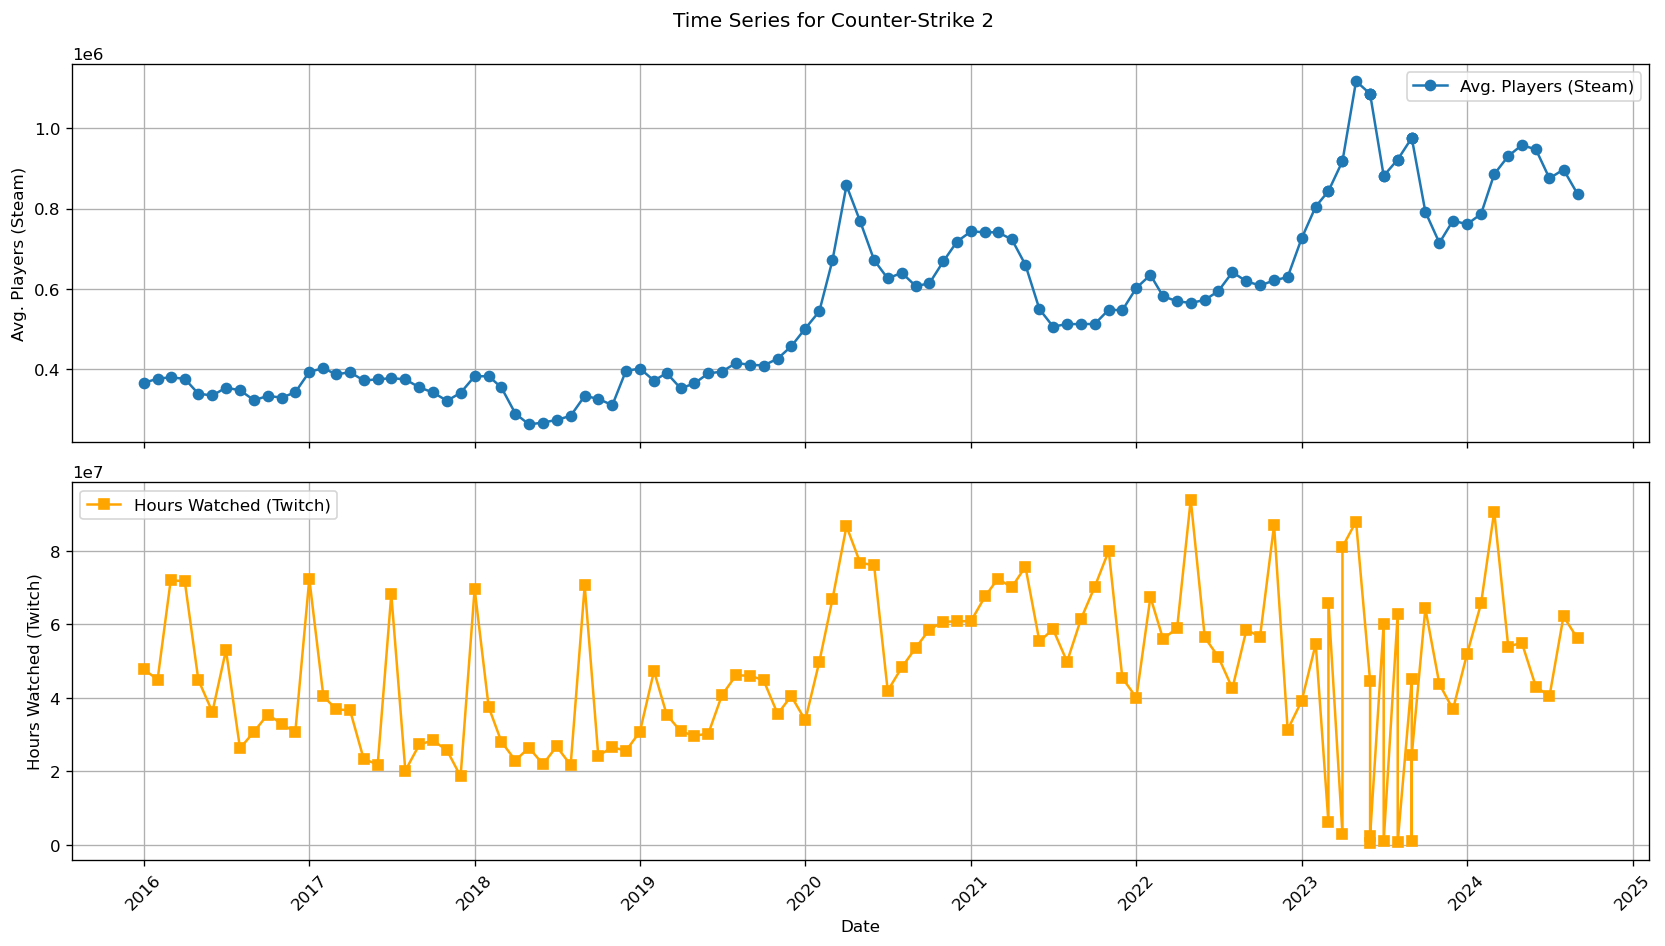

In [ ]:

# Replace with the name of the game you want to plot
names = ['Counter-Strike 2', 'PUBG: BATTLEGROUNDS', 'Dota 2', 'Apex Legends', 'Team Fortress 2']
selected_game = 'Dota 2'

# Filter the DataFrame for the selected game
game_df = df[df['Game_Name'] == selected_game].copy()

# Create two subplots: one for Avg. Players, one for Hours Watched
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# Plot the average players on the first subplot
if 'Avg. Players' in game_df.columns:
    axes[0].plot(
        game_df['Date'],
        game_df['Avg. Players'],
        marker='o',
        linestyle='-',
        label='Avg. Players (Steam)'
    )
    axes[0].set_ylabel('Avg. Players (Steam)')
    axes[0].legend()
    axes[0].grid(True)

# Plot the Twitch hours watched on the second subplot
if 'Hours_watched' in game_df.columns:
    axes[1].plot(
        game_df['Date'],
        game_df['Hours_watched'],
        marker='s',
        linestyle='-',
        color='orange',
        label='Hours Watched (Twitch)'
    )
    axes[1].set_ylabel('Hours Watched (Twitch)')
    axes[1].legend()
    axes[1].grid(True)

# Format the overall figure
plt.suptitle(f"Time Series for {selected_game}")
axes[-1].set_xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()